# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

**Context** <br>
The purpose of this project is to create a multivariate regression algorithm to try and predict the cost of health insurance bills for different people. This can be useful to people as they can know what to expect when it comes to paying for health insurance; this will allow them to now if they're overpaying or it will help them plan a budget beforehand. <br>
Root mean squared error will be the main error evaluator as it's a commonly standard for multivariate regression algorithms. The dataset used includes 1338 entries where age, sex, bmi, children status, smoker status, geographic region, and insurance charges are given for different patients.

In [104]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
insurance  = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [105]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [106]:
nulls = insurance.isnull().sum()
print("Number of missing values in each column:")
print(nulls)

Number of missing values in each column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [107]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING 

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

In [108]:
print("Feature Correlations:")
insurance.corr()

Feature Correlations:


,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [109]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#Create Train, Validation, Test
X_train, X_test = train_test_split(insurance, test_size=0.2, random_state=42)

# Your code goes here for this section.
y_train = X_train['charges']
X_train.drop(['charges'], axis = 1, inplace = True);
y_test = X_test['charges']
X_test.drop(['charges'], axis = 1, inplace = True);

#Split into numeric and categorical data
X_num = X_train._get_numeric_data()
numeric_columns = X_num.columns #numerical features
X_cat = X_train.drop(numeric_columns, axis = 1)

#Create pipeline
num_attribs = list(X_num)
cat_attribs = list(X_cat)

full_pipeline = ColumnTransformer([
        ("std_scaler", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
#Insert X_0, a column of ones
X_train_prepared = np.insert(X_train_prepared, 0, 1, axis=1)
X_test_prepared = full_pipeline.transform(X_test)
#Insert X_0, a column of ones
X_test_prepared = np.insert(X_test_prepared, 0, 1, axis=1)

In [110]:
X_train_prepared.shape

(1070, 12)

In [111]:
X_test_prepared.shape

(268, 12)

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT 
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [112]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = []; # parameter vector;
    self.alpha = []; # learning rate
    self.cost  = []; # cost function

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here

    tempCost = []
    m = 1070 #X_train_prepared has 1070 
    for iterations in range(iters):
      gradients = (2/m) * X_train.T.dot(X_train.dot(theta) - y_train)
      theta = theta - alpha * gradients
      tempError = X_train.dot(theta) - y_train
      tempRMSE = np.sqrt(np.mean(tempError**2))
      tempCost.append(tempRMSE)

    error = X_train.dot(theta) - y_train
    RMSE = np.sqrt(np.mean(error**2))

    return RMSE, theta, tempCost

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    tempAlpha = np.linspace(0, 1, 101)
    tempTheta = []
    tempIter = 1000
    tempError = []
    tempCosts = []
    bestAlpha = 0

    for i in tempAlpha:
      gd = self.gradientDescent(X_train, y_train, [1,1,1,1,1,1,1,1,1,1,1,1], i, tempIter)
      if len(tempError) == 0:
        tempTheta = gd[1]
        tempError.append(gd[0])
        tempCosts = gd[2]
        bestAlpha = i
      elif tempError[0] > gd[0]:
        tempError[0] = gd[0]
        tempTheta = gd[1]
        tempCosts = gd[2]
        bestAlpha = i
      
    self.theta = tempTheta
    self.alpha = bestAlpha
    self.cost = tempCosts

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    optimal_theta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
    self.theta = optimal_theta;

  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here 
    y_predict = X_test.dot(self.theta)
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    return("Parameter vector is %s" % self.theta)
    
# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()

myGradientDescentModel.fitUsingGradientDescent(X_train_prepared, y_train)

print(myGradientDescentModel.alpha)
print(myGradientDescentModel.cost)
print(myGradientDescentModel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in subtract


0.04
[16161.074700217698, 14814.029497480982, 13800.266457006845, 13030.803646195947, 12437.437722770774, 11969.54966214465, 11590.580854765705, 11274.679161997605, 11003.836913576357, 10765.631395597002, 10551.535569659072, 10355.701886916098, 10174.109070319222, 10003.9739381435, 9843.350632735588, 9690.859575990831, 9545.504972279052, 9406.552196418714, 9273.445444279452, 9145.752358088625, 9023.126692300933, 8905.283040747201, 8791.979634519836, 8683.006551178345, 8578.177563616766, 8477.324447675972, 8380.2929601995, 8286.939960062375, 8197.13131803502, 8110.740376643578, 8027.646798013869, 7947.735689003346, 7870.896927319463, 7797.024635476921, 7726.016765121725, 7657.7747649375115, 7592.20331269951, 7529.21009714866, 7468.705638950395, 7410.6031425642295, 7354.818372705296, 7301.2695504448675, 7249.877265020033, 7200.5643982024485, 7153.256058680769, 7107.879524387251, 7064.364191079601, 7022.641525796686, 6982.645024058556, 6944.310169888717, 6907.57439790907, 6872.37705690192

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

Text(0.5, 1.0, 'Error vs. Training Iterations for Alpha = 0.4')

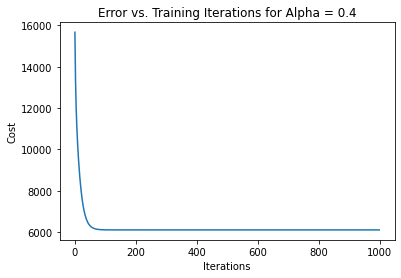

In [113]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.
#)
gd = myGradientDescentModel.gradientDescent(X_train_prepared, y_train, [1,1,1,1,1,1,1,1,1,1,1,1], 0.4, 1000)
plt.plot(gd[2])
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations for Alpha = 0.4')  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in subtract


Text(0.5, 1.0, 'Error vs. Training Iterations for Alpha = 0.8')

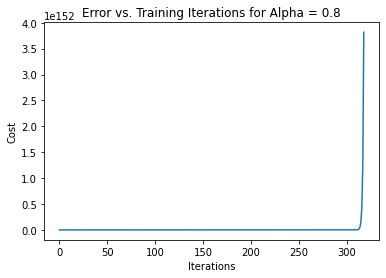

In [114]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.
#)
gd = myGradientDescentModel.gradientDescent(X_train_prepared, y_train, [1,1,1,1,1,1,1,1,1,1,1,1], 0.8, 1000)
plt.plot(gd[2])
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations for Alpha = 0.8')  

Text(0.5, 1.0, 'Error vs. Training Iterations for Alpha = 0.05')

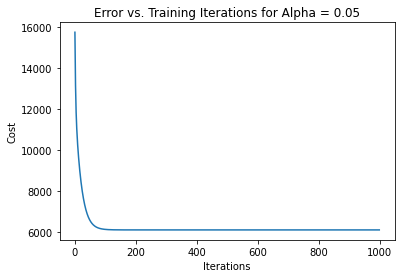

In [115]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.
#)
gd = myGradientDescentModel.gradientDescent(X_train_prepared, y_train, [1,1,1,1,1,1,1,1,1,1,1,1], 0.05, 1000)
plt.plot(gd[2])
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations for Alpha = 0.05')  

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [116]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train_prepared, y_train)

error = X_train_prepared.dot(myNormalEquationModel.theta) - y_train
RMSE = np.sqrt(np.mean(error**2))
print(RMSE)

6105.545160099847


- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS 

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [117]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train_prepared,y_train)
y_predict = mySGDModel.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print("SGDModel RMSE")
print(mySGDModel_rmse)

# myGradientDescentModel_rmse  
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared, y_train)

y_predict = myGradientDescentModel.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predict)
myGradientDescentModel_rmse = np.sqrt(mse)
print("myGradientDescentModel RMSE")
print(myGradientDescentModel_rmse)
# myNormalEquationModel_rmse 
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train_prepared, y_train)

y_predict = myNormalEquationModel.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predict)
myNormalEquationModel_rmse = np.sqrt(mse)
print("myNormalEquationModel RMSE")
print(myNormalEquationModel_rmse)

SGDModel RMSE
5804.296717032508


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in subtract


myGradientDescentModel RMSE
5796.2846620158825
myNormalEquationModel RMSE
5796.284659276274


- - -
## Task 6. PRESENT YOUR SOLUTION 

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

In [119]:
print(np.mean(y_test))

12968.317062869404


#Summary
The given features of age, sex, bmi, children status, smoker status, and patient geographical region are valid indicators to predict a person's insurance bills; however, they are not very strong indicators. Even using an extremely simple machine learning algorithm with minimal data engineering, we were able to create somewhat accurate predictions resulting in RMSEs around \$5800 when the average bill cost was around \$13000. The mediocre end predictions could have been foreseen by the also mediocre correlation values found ealrly on in the project. In order to further improve our predictions, more data entries could be collected, more features could be gathered, and a more complicated algorithm could be used.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!